Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [37]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import seaborn as sns

In [38]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [39]:
#Unzipping Assignment Data
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_

In [40]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [41]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [42]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [43]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size = batch_size, image_size = (img_height, img_width), seed = 123, validation_split = .2, subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [44]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size = batch_size, image_size = (img_height, img_width), seed = 123, validation_split = .2, subset = 'validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [45]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

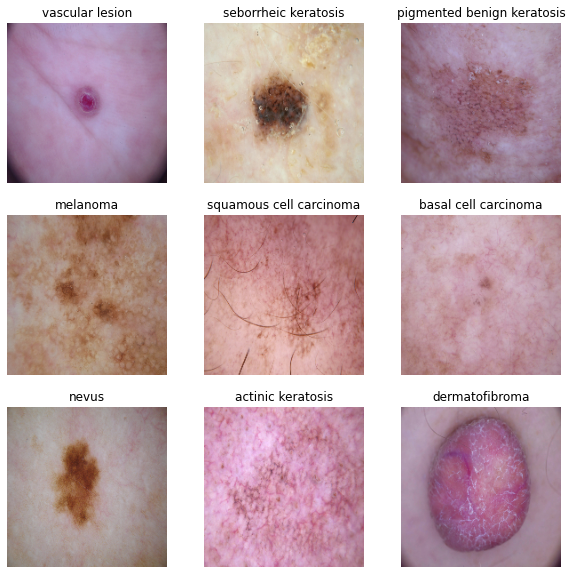

In [46]:
import matplotlib.pyplot as plt

all_class = []
val = 0 
plt.figure(figsize = (10,10))

for images, labels in train_ds:
    if len(all_class) == 9:
        break
        
    if class_names[labels[val]] in all_class:
        continue
        
    all_class.append(class_names[labels[val]])   
    ax = plt.subplot(3,3, val+1)
    plt.imshow(images[val].numpy().astype("uint8"))
    plt.title(class_names[labels[val]])
    plt.axis('off')
    val+=1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [48]:
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width,3)))
model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Conv2D(32, (3,3),  padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Conv2D(32, (3,3),  padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(num_classes, activation = 'softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [49]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [50]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 32)       

### Train the model

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 117ms/step - loss: 2.1744 - accuracy: 0.2035 - val_loss: 1.8978 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8582 - accuracy: 0.3395 - val_loss: 1.6075 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.6232 - accuracy: 0.4037 - val_loss: 1.4729 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3858 - accuracy: 0.5215 - val_loss: 1.3954 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3728 - accuracy: 0.5045 - val_loss: 1.3767 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.2094 - accuracy: 0.5463 - val_loss: 1.4454 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 3s 49ms/step - loss: 1.1918 - accuracy: 0.5879 - val_loss: 1.3900 - val_accuracy: 0.5190
Epoch 8/20


### Visualizing training results

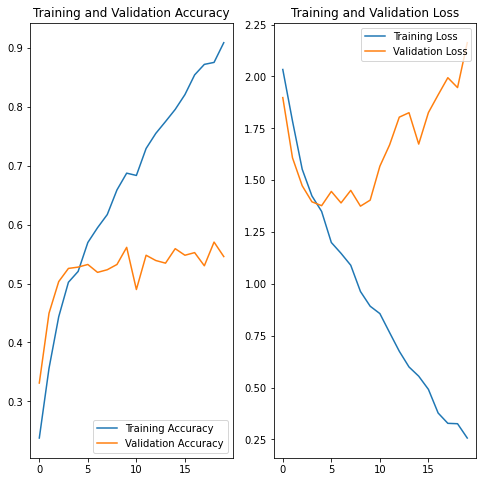

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 1. After applying optimizer as SGD the training and validation accuracy was pretty low after 20 epochs.
#### 2. After applying optimzer as ADAM , the training accuracy is high, however the validation accuracy is still low.
#### 3. There is a clear indication of model overfitting.

In [53]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed = 123),
  layers.experimental.preprocessing.RandomRotation(0.2, seed = 123),
  layers.experimental.preprocessing.RandomContrast(0.2, seed = 123),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), seed = 123),
])

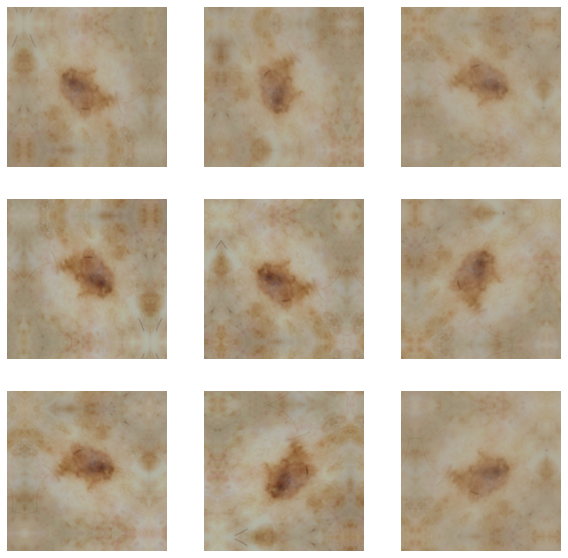

In [54]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
image, label = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  im = augmented_image[0]
  plt.imshow(im.numpy().astype('uint8'))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [55]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3),  padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3),  padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(num_classes, activation = 'softmax'))



### Compiling the model

In [56]:
model.compile(optimizer = 'adam', 
              loss = tf.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

### Training the model

In [57]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs = epochs)

Epoch 1/20
56/56 [==============================] - 5s 68ms/step - loss: 2.9897 - accuracy: 0.1604 - val_loss: 2.0901 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 2.0209 - accuracy: 0.2257 - val_loss: 2.0474 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 1.9747 - accuracy: 0.2495 - val_loss: 1.9027 - val_accuracy: 0.3132
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.8908 - accuracy: 0.3137 - val_loss: 1.8394 - val_accuracy: 0.2796
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.8141 - accuracy: 0.3327 - val_loss: 1.7608 - val_accuracy: 0.3311
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.6991 - accuracy: 0.3878 - val_loss: 1.6867 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 1.6562 - accuracy: 0.3880 - val_loss: 1.6624 - val_accuracy: 0.3758
Epoch 8/20
56

### Visualizing the results

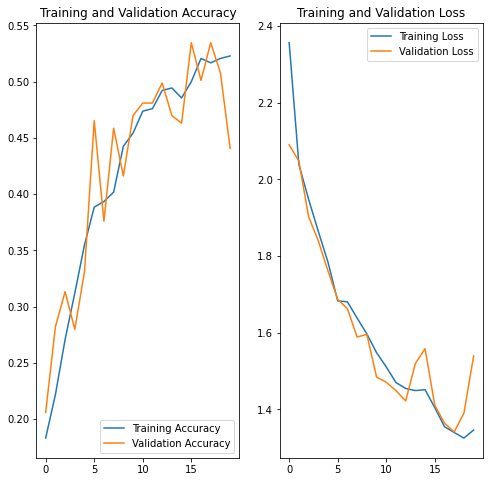

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 1. The training accuracy has fallen.
#### 2. There is clear indication that model is underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [59]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*' ,'*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in path_list]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()), columns=['Path', 'Label'])

In [60]:
normalize_df = original_df['Label'].value_counts(normalize=True) * 100
abs_df = original_df['Label'].value_counts()
grp_df = pd.concat([normalize_df, abs_df], axis = 1)
grp_df.columns = ['Proportinate Value','Absolutes number of images']

                            Proportinate Value  Absolutes number of images
pigmented benign keratosis           20.634212                         462
melanoma                             19.562305                         438
basal cell carcinoma                 16.793211                         376
nevus                                15.944618                         357
squamous cell carcinoma               8.083966                         181
vascular lesion                       6.208129                         139
actinic keratosis                     5.091559                         114
dermatofibroma                        4.242966                          95
seborrheic keratosis                  3.439035                          77


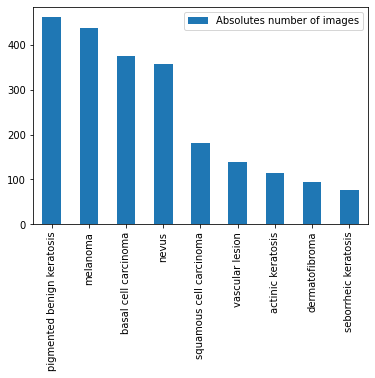

In [61]:
print(grp_df)
grp_df[['Absolutes number of images']].plot(kind = 'bar')
plt.show()

#### **Todo:** Write your findings here: 
#### Above data and barchart clearly indicates below points
#### - 'Seborrheic keratosis' has the least number of samples present in the dataset.
#### - Pigmented benign keratosis and Melanoma classes dominate the data in terms proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [62]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [63]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1FE786B6D0>:   0%|          | 1/500 [00:00<01:08,  7.32 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1FE7779290>: 100%|██████████| 500/500 [00:18<00:00, 26.69 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FE7814290>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FE9AA2490>: 100%|██████████| 500/500 [00:18<00:00, 26.55 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2054684590>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F2054527D50>: 100%|██████████| 500/500 [01:32<00:00,  5.39 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1FE99BF890>:   0%|          | 2/500 [00:00<00:31, 15.74 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1FE7A06B90>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F209CC9EBD0>: 100%|██████████| 500/500 [00:48<00:00, 10.22 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1FE9B0BE10>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F20AE250190>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [64]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [65]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011121.jpg_e2a11f42-5da9-4392-b12f-e03d1e8fb1b3.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010900.jpg_8fd38049-12b8-456a-8edd-b961ff402069.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011135.jpg_b8c193ac-48f2-4721-9a15-7d533304778d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010923.jpg_62fc2947-af8a-4217-b819-81d24baa74cf.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010917.jpg_e56f1de2-c366-47c9-88e1-369526ca0c63.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaborat

In [66]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [67]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [68]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [69]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [70]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [71]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [73]:
num_classes = 9
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width,3)))
model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3),  padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3,3),  padding = 'same', activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(num_classes, activation = 'softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [74]:
model.compile(optimizer = 'adam',
              loss = tf.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

#### **Todo:**  Train your model

In [75]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs)

Epoch 1/30
169/169 [==============================] - 47s 268ms/step - loss: 2.6056 - accuracy: 0.1373 - val_loss: 2.1874 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 45s 258ms/step - loss: 2.1808 - accuracy: 0.1335 - val_loss: 2.1884 - val_accuracy: 0.1403
Epoch 3/30
169/169 [==============================] - 45s 257ms/step - loss: 2.1772 - accuracy: 0.1368 - val_loss: 2.1875 - val_accuracy: 0.1403
Epoch 4/30
169/169 [==============================] - 45s 261ms/step - loss: 2.1772 - accuracy: 0.1381 - val_loss: 2.1891 - val_accuracy: 0.1403
Epoch 5/30
169/169 [==============================] - 44s 253ms/step - loss: 2.1711 - accuracy: 0.1535 - val_loss: 2.1883 - val_accuracy: 0.1403
Epoch 6/30
169/169 [==============================] - 45s 262ms/step - loss: 2.1782 - accuracy: 0.1418 - val_loss: 2.1862 - val_accuracy: 0.1425
Epoch 7/30
169/169 [==============================] - 45s 261ms/step - loss: 2.1752 - accuracy: 0.1335 - val_loss: 2.1690 - val_ac

#### **Todo:**  Visualize the model results

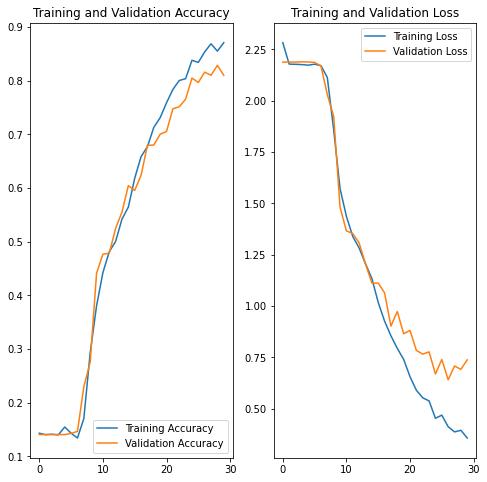

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 1. Model training accuracy and validation accuracy drastically improved, now model is neither overfitted nor underfitted.
#### 2. Class rebalance helped in achieving this feat where the validation and training accuracy are comparable and both shows good results. 

